# Washington DC Crime Analysis 
### DATA 602: Introduction to Data Analysis and Machine Learning
Authors: Joanne Choi, Sam Clark, Peter Kirk, William Simpson, Levan Sulimanov

#### Import libraries

In [1]:
!pip install geopandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')
import datetime
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import CRS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report, mean_squared_error, r2_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import statsmodels.api as sm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import Data & Process Data

In [3]:
# shape datasets for crime hotspot analysis
border_map = gpd.read_file('/content/drive/MyDrive/shapefiles/Washington_DC_Boundary.shp')
street_map = gpd.read_file('/content/drive/MyDrive/shapefiles/Roads.shp')

In [4]:
# Main files:
# precovid_crime_micro_geo_11_29_2021
# covid_crime_micro_geo_11_29_2021

precovid = pd.read_csv('https://raw.githubusercontent.com/joannechoi/DC-Crime-Analysis/main/Data/Merged/precovid_crime_micro_geo_11_29_2021.csv', index_col=False)
covid = pd.read_csv('https://raw.githubusercontent.com/joannechoi/DC-Crime-Analysis/main/Data/Merged/covid_crime_micro_geo_11_29_2021.csv', index_col=False)

In [5]:
# preview of the precovid data
precovid.sample(5)

,Unnamed: 0,SHIFT,OFFENSE,WARD,LATITUDE,LONGITUDE,date,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
70606,70606,EVENING,THEFT/OTHER,6.0,38.910386,-77.023969,2019-06-30,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.150524,0.100141,0.020156
100374,105124,MIDNIGHT,THEFT F/AUTO,6.0,38.904903,-77.019900,2020-01-05,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.141944,0.092692,0.018533
18169,18169,DAY,THEFT/OTHER,3.0,38.956470,-77.065400,2017-12-02,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0.264591,0.695894,0.139118
37083,37083,MIDNIGHT,THEFT/OTHER,7.0,38.860313,-76.965837,2018-06-27,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0.883188,1.029796,0.093429
21240,21240,EVENING,THEFT F/AUTO,6.0,38.896122,-77.010245,2017-04-29,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.197896,0.149134,0.023680


In [6]:
# preview of the covid data
covid.sample(5)

,Unnamed: 0,SHIFT,OFFENSE,WARD,LATITUDE,LONGITUDE,date,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
33962,138316,EVENING,THEFT F/AUTO,5.0,38.914826,-77.013276,2021-09-19,0.0,0.0,0.0,52.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.373872,0.368641,0.042850
41333,145691,EVENING,THEFT/OTHER,2.0,38.905089,-77.057578,2021-01-29,36662.0,248.0,2.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.462426,0.167494,0.038948
128,98159,MIDNIGHT,THEFT/OTHER,7.0,38.902147,-76.935628,2020-08-27,13851.0,57.0,0.0,90.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0.098125,2.555727,0.025188
1176,99207,EVENING,THEFT F/AUTO,2.0,38.914463,-77.041660,2020-09-27,15264.0,14.0,0.0,62.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.143365,0.127814,0.078679
6942,108463,DAY,THEFT F/AUTO,3.0,38.958049,-77.071584,2020-04-29,4323.0,217.0,19.0,111.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.573354,0.580562,0.076718


### EDA

Crime count by type before Covid-19
------------------------------------
THEFT/OTHER                   46060
THEFT F/AUTO                  33638
MOTOR VEHICLE THEFT            7247
ROBBERY                        6560
ASSAULT W/DANGEROUS WEAPON     5193
BURGLARY                       4368
SEX ABUSE                       801
HOMICIDE                        472
ARSON                            20
Name: OFFENSE, dtype: int64


Crime count by type during Covid-19
------------------------------------
THEFT/OTHER                   16367
THEFT F/AUTO                  12809
MOTOR VEHICLE THEFT            5552
ROBBERY                        3168
ASSAULT W/DANGEROUS WEAPON     2636
BURGLARY                       2026
HOMICIDE                        332
SEX ABUSE                       261
ARSON                            13
Name: OFFENSE, dtype: int64


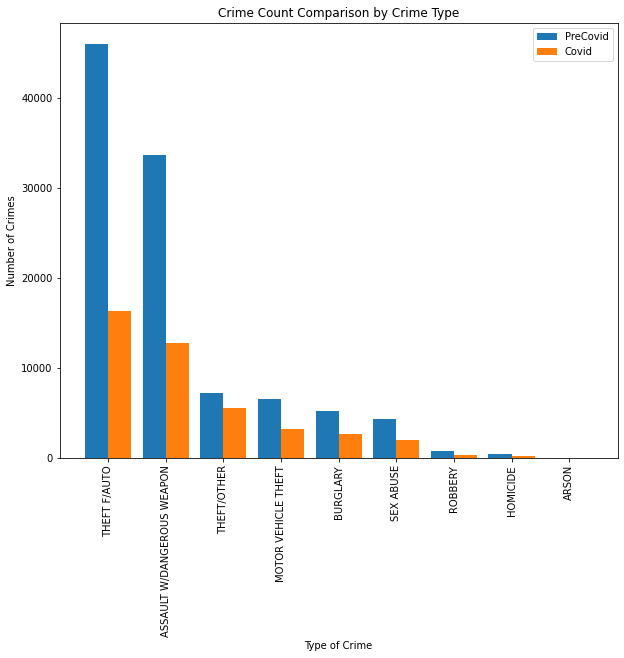

In [7]:
crimeTypes = precovid["OFFENSE"].unique()
precovid_types = precovid['OFFENSE'].value_counts()
covid_types = covid['OFFENSE'].value_counts()

print("Crime count by type before Covid-19")
print("------------------------------------")
print(precovid_types)
print('\n')
print("Crime count by type during Covid-19")
print("------------------------------------")
print(covid_types)

plt.figure(figsize=(10, 8))

x = np.arange(len(crimeTypes))
plt.bar(x - 0.2, precovid_types, 0.4, label = 'PreCovid')
plt.bar(x + 0.2, covid_types, 0.4, label = 'Covid')

plt.xticks(x, crimeTypes, rotation = 90)
plt.xlabel("Type of Crime")
plt.ylabel("Number of Crimes")
plt.title("Crime Count Comparison by Crime Type")
plt.legend()
plt.show()

Crime count by ward before Covid-19
------------------------------------
1.0    14776
2.0    19413
3.0     5908
4.0     9567
5.0    16016
6.0    16683
7.0    12540
8.0     9456
Name: WARD, dtype: int64


Crime count by ward during Covid-19
------------------------------------
1.0    5998
2.0    6712
3.0    2301
4.0    4101
5.0    6779
6.0    7683
7.0    5417
8.0    4173
Name: WARD, dtype: int64


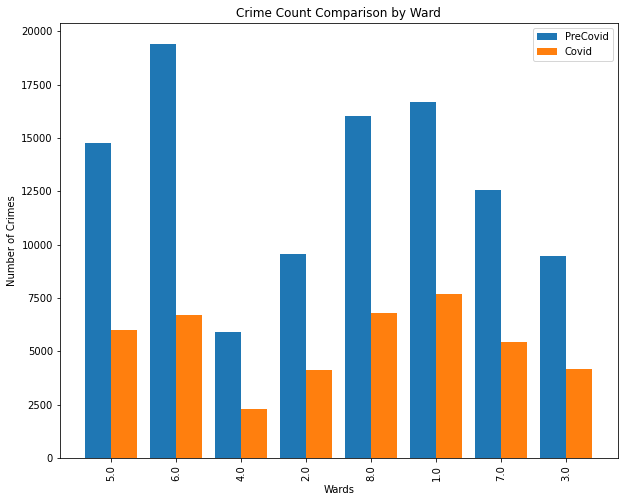

In [8]:
# view crime count by ward before and during covid
wards = precovid["WARD"].unique()
#x_wards = wards.sort()
precovid_wards = precovid['WARD'].value_counts().sort_index()
covid_wards = covid['WARD'].value_counts().sort_index()

print("Crime count by ward before Covid-19")
print("------------------------------------")
print(precovid_wards)
print('\n')
print("Crime count by ward during Covid-19")
print("------------------------------------")
print(covid_wards)

plt.figure(figsize=(10, 8))

x=np.arange(len(wards))
plt.bar(x - 0.2, precovid_wards, 0.4, label = 'PreCovid')
plt.bar(x + 0.2, covid_wards, 0.4, label = 'Covid')

plt.xticks(x, wards, rotation = 90)
plt.xlabel("Wards")
plt.ylabel("Number of Crimes")
plt.title("Crime Count Comparison by Ward")
plt.legend()
plt.show()

Crime count by month before Covid-19
------------------------------------
1     10881
2      9183
3      7813
4      7501
5      8308
6      8397
7      8807
8      8944
9      8786
10     9124
11     8261
12     8354
Name: date, dtype: int64


Crime count by month during Covid-19
------------------------------------
1     2025
2     1705
3     3155
4     3486
5     4360
6     4691
7     4818
8     4677
9     5320
10    4264
11    2424
12    2239
Name: date, dtype: int64


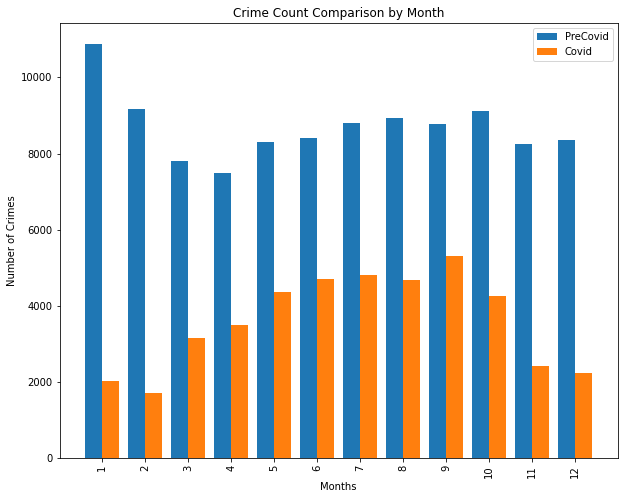

In [9]:
# view crime count by month before and during covid
precovid['date'] = precovid['date'].astype('datetime64')
covid['date'] = covid['date'].astype('datetime64')
months_p = precovid['date'].dt.month
months_c = covid['date'].dt.month
precovid_months = months_p.value_counts().sort_index()
covid_months = months_c.value_counts().sort_index()

print("Crime count by month before Covid-19")
print("------------------------------------")
print(precovid_months)
print('\n')
print("Crime count by month during Covid-19")
print("------------------------------------")
print(covid_months)

plt.figure(figsize=(10, 8))

x = np.arange(12)
plt.bar(x - 0.2, precovid_months, 0.4, label = 'PreCovid')
plt.bar(x + 0.2, covid_months, 0.4, label = 'Covid')

months = range(1,13)

plt.xticks(x, months, rotation = 90)
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.title("Crime Count Comparison by Month")
plt.legend()
plt.show()

#### Crime Hotspot Analysis 

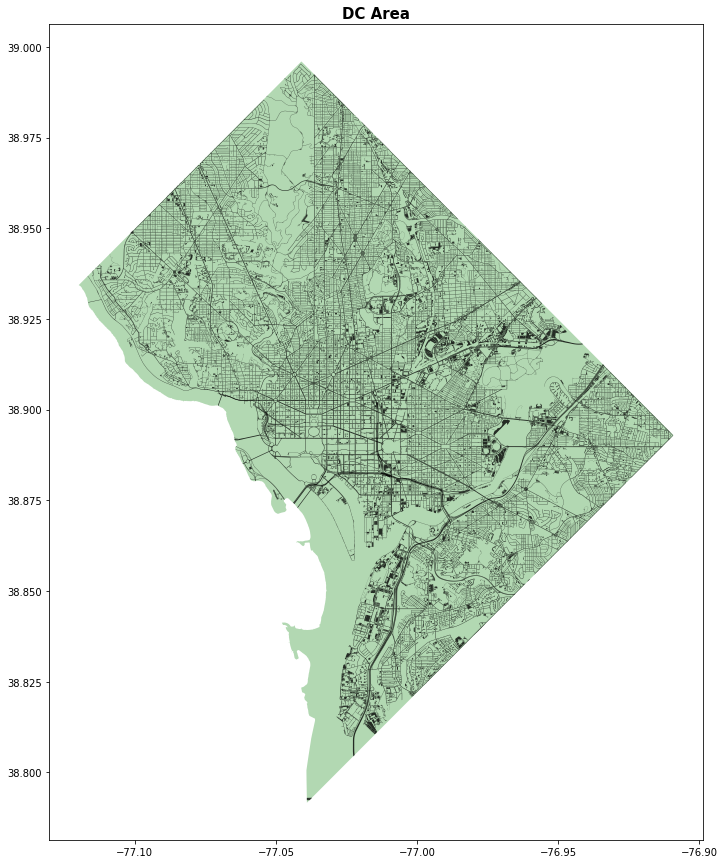

In [10]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
border_map.plot(ax=ax, alpha=0.3, color='green')
street_map.plot(ax=ax, alpha=0.8, color='black')
# add title to graph
plt.title('DC Area', fontsize=15,fontweight='bold')
plt.show()

In [11]:
crs=CRS('EPSG:4326')
geo_precovid = precovid.copy()
geo_covid = covid.copy()
geometry_pre_covid = [Point(xy) for xy in zip(geo_precovid['LONGITUDE'], geo_precovid['LATITUDE'])]

# create GeoPandas dataframe
geo_df_pre_covid = gpd.GeoDataFrame(geo_precovid, crs = crs, geometry = geometry_pre_covid)

geometry_post_covid = [Point(xy) for xy in zip(geo_covid['LONGITUDE'], geo_covid['LATITUDE'])]
geo_df_post_covid = gpd.GeoDataFrame(geo_covid, crs = crs, geometry = geometry_post_covid)

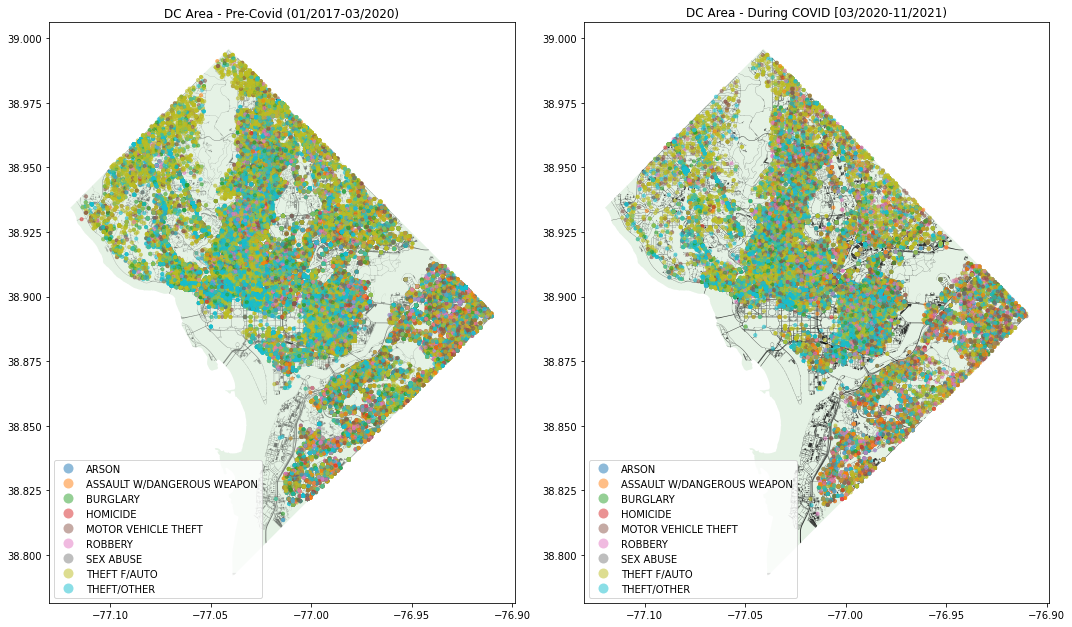

In [12]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
border_map.plot(ax=ax[0], alpha=0.1, color='green')
street_map.plot(ax=ax[0], alpha=0.5, color='black')

# overlay samples
geo_df_pre_covid.plot(column='OFFENSE',ax=ax[0],alpha=0.5, legend=True,markersize=10)

# add title to graph
ax[0].title.set_text('DC Area - Pre-Covid (01/2017-03/2020)')

# create figure and axes, assign to subplot
border_map.plot(ax=ax[1], alpha=0.1, color='green')
street_map.plot(ax=ax[1], alpha=0.8, color='black')

# overlay samples
geo_df_post_covid.plot(column='OFFENSE',ax=ax[1],alpha=0.5, legend=True,markersize=10)

# add title to graph
ax[1].title.set_text('DC Area - During COVID [03/2020-11/2021)')

fig.tight_layout()

### Data Processing for Model Training

### Previous method of data processing

In [13]:
pre_covid_data = precovid.drop(columns=['Unnamed: 0', 'SHIFT','OFFENSE', 'LATITUDE', 'LONGITUDE', 'ward_1', 'ward_2', 
                                              'ward_3', 'ward_4', 'ward_5', 'ward_6', 'ward_7', 'ward_8'])
covid_data = covid.drop(columns=['Unnamed: 0', 'SHIFT','OFFENSE', 'LATITUDE', 'LONGITUDE', 'ward_1', 'ward_2', 
                                              'ward_3', 'ward_4', 'ward_5', 'ward_6', 'ward_7', 'ward_8'])

pre_covid_data['WARD'] = pre_covid_data['WARD'].astype(int)
covid_data['WARD'] = covid_data['WARD'].astype(int)

In [14]:
pre_covid_data.sample(3)

,WARD,date,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
82726,1,2019-11-20,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.338076,0.432132,0.027513
90324,5,2019-02-14,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.257486,0.209793,0.036631
5048,5,2017-04-16,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.084503,0.849526,0.047963


In [15]:
covid_data.sample(3)

,WARD,date,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
41198,6,2021-02-02,37199.0,61.0,5.0,104.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.289096,0.184777,0.039056
6115,6,2020-04-16,2476.0,126.0,0.0,196.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.203469,0.430767,0.042910
43035,8,2021-01-17,34033.0,182.0,7.0,176.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.430983,0.811966,0.067230


In [16]:
# Baseline:
x_PRE_COVID_baseline_not_scaled = pre_covid_data.loc[:, pre_covid_data.columns != 'WARD']
del x_PRE_COVID_baseline_not_scaled["total_cases"]
del x_PRE_COVID_baseline_not_scaled["daily_cases"]
del x_PRE_COVID_baseline_not_scaled["daily_death"]
del x_PRE_COVID_baseline_not_scaled["OUT_POSITIVE_QUARANTINE_PSMPD"]

x_COVID_baseline_not_scaled = covid_data.loc[:, pre_covid_data.columns != 'WARD']

# Experiment:
x_PRE_COVID_experiment_not_scaled = covid_data.loc[:, pre_covid_data.columns != 'WARD']
del x_PRE_COVID_experiment_not_scaled["total_cases"]
del x_PRE_COVID_experiment_not_scaled["daily_cases"]
del x_PRE_COVID_experiment_not_scaled["daily_death"]
del x_PRE_COVID_experiment_not_scaled["OUT_POSITIVE_QUARANTINE_PSMPD"]

x_COVID_experiment_not_scaled = pre_covid_data.loc[:, pre_covid_data.columns != 'WARD']

# Labels:
y_PRE_COVID_base = pre_covid_data['WARD']
y_COVID_base = covid_data['WARD']

y_PRE_COVID_experiment = covid_data['WARD']
y_COVID_experiment = pre_covid_data['WARD']

In [17]:
x_PRE_COVID_baseline_not_scaled.sample(3)

,date,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
27091,2017-02-22,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.074664,0.570473,0.063863
78112,2019-09-05,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.494413,0.369447,0.032223
82995,2019-12-19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0.596326,0.569251,0.107774


In [18]:
x_COVID_baseline_not_scaled.sample(3)

,date,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
19718,2020-08-23,13639.0,49.0,0.0,97.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.172352,0.243665,0.036011
14538,2020-11-10,18379.0,206.0,0.0,93.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1.037934,0.856591,0.139763
8058,2020-05-04,5322.0,152.0,6.0,105.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.552818,0.386849,0.138530


In [19]:
x_PRE_COVID_experiment_not_scaled.sample(3)

,date,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
12643,2020-07-13,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0.197085,0.098560,0.071243
21130,2021-03-24,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.232622,0.736653,0.035868
9555,2020-03-28,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.129458,0.328195,0.187450


In [20]:
x_COVID_experiment_not_scaled.sample(3)

,date,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
73119,2019-05-06,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.281105,0.671276,0.140100
15102,2017-12-29,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.105978,0.228637,0.035858
54154,2018-02-21,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.413966,0.229051,0.005895


In [21]:
del x_PRE_COVID_baseline_not_scaled['date']
del x_COVID_baseline_not_scaled['date']
del x_PRE_COVID_experiment_not_scaled['date']
del x_COVID_experiment_not_scaled['date']

### ML Algorithms


1.   Logistic Regression
2.   Decision Tree
2.   Random Forest
3.   Gradient Boost
4.   KNN
5.   SVC

In [22]:
def cross_validation(x_PRE_COVID_baseline_not_scaled, y_PRE_COVID_base, x_COVID_baseline_not_scaled, y_COVID_base, 
                     x_PRE_COVID_experiment_not_scaled, y_PRE_COVID_experiment, x_COVID_experiment_not_scaled, y_COVID_experiment,
                     model):   
  # get original data
  random_state = [1, 10, 25, 40, 50]

  ###################
  cross_val_score_lst_PRE_COVID_MODEL_base = []
  pr_lst_PRE_COVID_MODEL_base = [] # list of [Precision, Recall] tuples from each Fold

  cross_val_score_lst_COVID_MODEL_base = []
  pr_lst_COVID_MODEL_base = [] # list of [Precision, Recall] tuples from each Fold

  ###################
  cross_val_score_lst_TEST_ONLY_PRE_COVID_MODEL_ON_COVID_experiment = []
  pr_lst_PRE_COVID_MODEL_ON_COVID_experiment = []

  cross_val_score_lst_TEST_ONLY_COVID_MODEL_ON_PRE_COVID_experiment = []
  pr_lst_COVID_MODEL_ON_PRE_COVID_experiment = []

  ###################
  # go through validation splits
  for val in range(0, 5):
      
      state_idx = val
      ############################
      #### GET Nth VALIDATION ####
      ############################
      # get Nth validation
      # Baseline:
      curr_X_train_PRE_COVID_unscaled_base, curr_X_test_PRE_COVID_unscaled_base, curr_y_train_PRE_COVID_base, curr_y_test_PRE_COVID_base = train_test_split(x_PRE_COVID_baseline_not_scaled, 
                                                                                                                                                            y_PRE_COVID_base,
                                                                                                                                                            test_size=0.3,
                                                                                                                                                            shuffle=True,
                                                                                                                                                            random_state=random_state[state_idx])
      
      curr_X_train_COVID_unscaled_base, curr_X_test_COVID_unscaled_base, curr_y_train_COVID_base, curr_y_test_COVID_base = train_test_split(x_COVID_baseline_not_scaled,
                                                                                                                                            y_COVID_base, 
                                                                                                                                            test_size=0.3, 
                                                                                                                                            shuffle=True,
                                                                                                                                            random_state=random_state[state_idx])
      # Experiment
      curr_X_train_PRE_COVID_unscaled_experiment, curr_X_test_PRE_COVID_unscaled_experiment, curr_y_train_PRE_COVID_experiment, curr_y_test_PRE_COVID_experiment = train_test_split(x_PRE_COVID_experiment_not_scaled,
                                                                                                                                                                                    y_PRE_COVID_experiment,
                                                                                                                                                                                    test_size=0.3, 
                                                                                                                                                                                    shuffle=True,
                                                                                                                                                                                    random_state=random_state[state_idx])
      
      curr_X_train_COVID_unscaled_experiment, curr_X_test_COVID_unscaled_experiment, curr_y_train_COVID_experiment, curr_y_test_COVID_experiment = train_test_split(x_COVID_experiment_not_scaled, 
                                                                                                                                                                    y_COVID_experiment, 
                                                                                                                                                                    test_size=0.3, 
                                                                                                                                                                    shuffle=True,
                                                                                                                                                                    random_state=random_state[state_idx])
      print("Dataset shapes:")
      print("  X_train_PRE_COVID_Baseline:", curr_X_train_PRE_COVID_unscaled_base.shape)
      print("  X_train_PRE_COVID_Experiment:", curr_X_train_PRE_COVID_unscaled_experiment.shape)
      print("")
      print("  X_train_COVID_Baseline:", curr_X_train_COVID_unscaled_base.shape)
      print("  X_train_COVID_Experiment:", curr_X_train_COVID_unscaled_experiment.shape)
      
      # Setup scaler and train on according baseline trains
      MinMax_scaler_PRE_COVID = MinMaxScaler(feature_range=(0, 1))
      MinMax_scaler_PRE_COVID = MinMax_scaler_PRE_COVID.fit(curr_X_train_PRE_COVID_unscaled_base) # Baseline Pre-COVID Train

      MinMax_scaler_COVID = MinMaxScaler(feature_range=(0, 1))
      MinMax_scaler_COVID = MinMax_scaler_COVID.fit(curr_X_train_COVID_unscaled_base) # Baseline COVID Train
      
      ####################
      #### SCALE DATA ####
      ####################
      # Scale the data (Base one, and experiment one)
      # For PRE_COVID:
      curr_x_train_PRE_COVID_base = MinMax_scaler_PRE_COVID.transform(curr_X_train_PRE_COVID_unscaled_base) # For training Pre-COVID model
      curr_x_test_PRE_COVID_base = MinMax_scaler_PRE_COVID.transform(curr_X_test_PRE_COVID_unscaled_base) # For testing Pre-COVID model (base)
      curr_x_test_PRE_COVID_on_COVID_experiment = MinMax_scaler_PRE_COVID.transform(curr_X_test_PRE_COVID_unscaled_experiment) # For testing Pre-COVID on COVID (experiment)

      # For COVID:
      curr_x_train_COVID_base = MinMax_scaler_COVID.transform(curr_X_train_COVID_unscaled_base) # For training COVID model
      curr_x_test_COVID_base = MinMax_scaler_COVID.transform(curr_X_test_COVID_unscaled_base) # For testing COVID model (base)
      curr_x_test_COVID_on_PRE_COVID_experiment = MinMax_scaler_COVID.transform(curr_X_test_COVID_unscaled_experiment) # For testing COVID on Pre-COVID (experiment)
      
      #############################
      #### PRE-COVID PRE-MODEL ####
      #############################
      curr_model_PRE_COVID = model
      #LogisticRegression(multi_class='multinomial', max_iter=500) #SVC(C=41, kernel='rbf') # SET YOUR MODEL HERE WITH ALL SELECTED HYPERPARAMETERS AND OTHER SETTINGS
      curr_model_PRE_COVID.fit(curr_x_train_PRE_COVID_base, curr_y_train_PRE_COVID_base)
      # Get Pre-COVID Baseline:
      curr_accuracy_PRE_COVID_base = accuracy_score(curr_y_test_PRE_COVID_base, 
                                                    curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_base))
      curr_precision_PRE_COVID_base = precision_score(curr_y_test_PRE_COVID_base, 
                                                      curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_base),
                                                      average='macro') 
      curr_recall_PRE_COVID_base = recall_score(curr_y_test_PRE_COVID_base, 
                                                curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_base),
                                                average='macro')
      
      cross_val_score_lst_PRE_COVID_MODEL_base.append(curr_accuracy_PRE_COVID_base)
      pr_lst_PRE_COVID_MODEL_base.append([curr_precision_PRE_COVID_base, curr_recall_PRE_COVID_base])
      
      
      # Get Pre-COVID Experiment:
      curr_accuracy_PRE_COVID_experiment = accuracy_score(curr_y_test_PRE_COVID_experiment, 
                                                          curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_on_COVID_experiment))
      curr_precision_PRE_COVID_experiment = precision_score(curr_y_test_PRE_COVID_experiment, 
                                                            curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_on_COVID_experiment),
                                                            average='macro') 
      curr_recall_PRE_COVID_experiment = recall_score(curr_y_test_PRE_COVID_experiment, 
                                                      curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_on_COVID_experiment),
                                                      average='macro')
      
      cross_val_score_lst_TEST_ONLY_PRE_COVID_MODEL_ON_COVID_experiment.append(curr_accuracy_PRE_COVID_experiment)
      pr_lst_PRE_COVID_MODEL_ON_COVID_experiment.append([curr_precision_PRE_COVID_experiment, curr_recall_PRE_COVID_experiment])
      
      
      #########################
      #### COVID PRE-MODEL ####
      #########################
      curr_model_COVID = model
      #LogisticRegression(multi_class='multinomial', max_iter=500) # SVC(C=41, kernel='rbf') # SET YOUR MODEL HERE WITH ALL SELECTED HYPERPARAMETERS AND OTHER SETTINGS
      curr_model_COVID.fit(curr_x_train_COVID_base, curr_y_train_COVID_base)
      # Get COVID Baseline:
      curr_accuracy_COVID_base = accuracy_score(curr_y_test_COVID_base, 
                                                curr_model_COVID.predict(curr_x_test_COVID_base))
      curr_precision_COVID_base = precision_score(curr_y_test_COVID_base, 
                                                  curr_model_COVID.predict(curr_x_test_COVID_base),
                                                  average='macro') 
      curr_recall_COVID_base = recall_score(curr_y_test_COVID_base, 
                                            curr_model_COVID.predict(curr_x_test_COVID_base),
                                            average='macro')
      
      cross_val_score_lst_COVID_MODEL_base.append(curr_accuracy_COVID_base)
      pr_lst_COVID_MODEL_base.append([curr_precision_COVID_base, curr_recall_COVID_base])
      
      
      # Get COVID Experiment:
      curr_accuracy_COVID_experiment = accuracy_score(curr_y_test_COVID_experiment, 
                                                      curr_model_COVID.predict(curr_x_test_COVID_on_PRE_COVID_experiment))
      curr_precision_COVID_experiment = precision_score(curr_y_test_COVID_experiment, 
                                                        curr_model_COVID.predict(curr_x_test_COVID_on_PRE_COVID_experiment),
                                                        average='macro') 
      curr_recall_COVID_experiment = recall_score(curr_y_test_COVID_experiment, 
                                                  curr_model_COVID.predict(curr_x_test_COVID_on_PRE_COVID_experiment),
                                                  average='macro')
      
      cross_val_score_lst_TEST_ONLY_COVID_MODEL_ON_PRE_COVID_experiment.append(curr_accuracy_COVID_experiment)
      pr_lst_COVID_MODEL_ON_PRE_COVID_experiment.append([curr_precision_COVID_experiment, curr_recall_COVID_experiment])
  return print("\n",
               "PRE-COVID Model Baseline:",
               "Accuracy scores from each fold:", cross_val_score_lst_PRE_COVID_MODEL_base,
               "Precision and Recall from each fold:", pr_lst_PRE_COVID_MODEL_base,
               '\n',
               "COVID Model Baseline:",
               "Accuracy scores from each fold:", cross_val_score_lst_COVID_MODEL_base,
               "Precision and Recall from each fold:", pr_lst_COVID_MODEL_base,
               '\n',
               "PRE-COVID Model Experiment (on COVID Data):",
               "Accuracy scores from each fold:", cross_val_score_lst_TEST_ONLY_PRE_COVID_MODEL_ON_COVID_experiment,
               "Precision and Recall from each fold:", pr_lst_PRE_COVID_MODEL_ON_COVID_experiment,
               '\n',
               "COVID Model Experiment (on Pre-COVID Data):",
               "Accuracy scores from each fold:", cross_val_score_lst_TEST_ONLY_COVID_MODEL_ON_PRE_COVID_experiment,
               "Precision and Recall from each fold:", pr_lst_COVID_MODEL_ON_PRE_COVID_experiment,
               sep='\n')

#### Logisitic Regression

In [23]:
lr = LogisticRegression(multi_class='multinomial', 
                                              C=100, 
                                              penalty='l2',
                                              solver='lbfgs',
                                              max_iter=200)

In [24]:
# get original data
random_state = [1, 10, 25, 40, 50]

###################
cross_val_score_lst_PRE_COVID_MODEL_base = []
pr_lst_PRE_COVID_MODEL_base = [] # list of [Precision, Recall] tuples from each Fold

cross_val_score_lst_COVID_MODEL_base = []
pr_lst_COVID_MODEL_base = [] # list of [Precision, Recall] tuples from each Fold

###################
cross_val_score_lst_TEST_ONLY_PRE_COVID_MODEL_ON_COVID_experiment = []
pr_lst_PRE_COVID_MODEL_ON_COVID_experiment = []

cross_val_score_lst_TEST_ONLY_COVID_MODEL_ON_PRE_COVID_experiment = []
pr_lst_COVID_MODEL_ON_PRE_COVID_experiment = []

###################
# go through validation splits
for val in range(0, 5):
    
    state_idx = val
    ############################
    #### GET Nth VALIDATION ####
    ############################
    # get Nth validation
    # Baseline:
    curr_X_train_PRE_COVID_unscaled_base, curr_X_test_PRE_COVID_unscaled_base, curr_y_train_PRE_COVID_base, curr_y_test_PRE_COVID_base = train_test_split(x_PRE_COVID_baseline_not_scaled, 
                                                                                                                                                          y_PRE_COVID_base,
                                                                                                                                                          test_size=0.3,
                                                                                                                                                          shuffle=True,
                                                                                                                                                          random_state=random_state[state_idx])
    
    curr_X_train_COVID_unscaled_base, curr_X_test_COVID_unscaled_base, curr_y_train_COVID_base, curr_y_test_COVID_base = train_test_split(x_COVID_baseline_not_scaled,
                                                                                                                                          y_COVID_base, 
                                                                                                                                          test_size=0.3, 
                                                                                                                                          shuffle=True,
                                                                                                                                          random_state=random_state[state_idx])
    # Experiment
    curr_X_train_PRE_COVID_unscaled_experiment, curr_X_test_PRE_COVID_unscaled_experiment, curr_y_train_PRE_COVID_experiment, curr_y_test_PRE_COVID_experiment = train_test_split(x_PRE_COVID_experiment_not_scaled,
                                                                                                                                                                                  y_PRE_COVID_experiment,
                                                                                                                                                                                  test_size=0.3, 
                                                                                                                                                                                  shuffle=True,
                                                                                                                                                                                  random_state=random_state[state_idx])
    
    curr_X_train_COVID_unscaled_experiment, curr_X_test_COVID_unscaled_experiment, curr_y_train_COVID_experiment, curr_y_test_COVID_experiment = train_test_split(x_COVID_experiment_not_scaled, 
                                                                                                                                                                  y_COVID_experiment, 
                                                                                                                                                                  test_size=0.3, 
                                                                                                                                                                  shuffle=True,
                                                                                                                                                                  random_state=random_state[state_idx])
    print("Dataset shapes:")
    print("  X_train_PRE_COVID_Baseline:", curr_X_train_PRE_COVID_unscaled_base.shape)
    print("  X_train_PRE_COVID_Experiment:", curr_X_train_PRE_COVID_unscaled_experiment.shape)
    print("")
    print("  X_train_COVID_Baseline:", curr_X_train_COVID_unscaled_base.shape)
    print("  X_train_COVID_Experiment:", curr_X_train_COVID_unscaled_experiment.shape)
    
    # Setup scaler and train on according baseline trains
    MinMax_scaler_PRE_COVID = MinMaxScaler(feature_range=(0, 1))
    MinMax_scaler_PRE_COVID = MinMax_scaler_PRE_COVID.fit(curr_X_train_PRE_COVID_unscaled_base) # Baseline Pre-COVID Train

    MinMax_scaler_COVID = MinMaxScaler(feature_range=(0, 1))
    MinMax_scaler_COVID = MinMax_scaler_COVID.fit(curr_X_train_COVID_unscaled_base) # Baseline COVID Train
    
    ####################
    #### SCALE DATA ####
    ####################
    # Scale the data (Base one, and experiment one)
    # For PRE_COVID:
    curr_x_train_PRE_COVID_base = MinMax_scaler_PRE_COVID.transform(curr_X_train_PRE_COVID_unscaled_base) # For training Pre-COVID model
    curr_x_test_PRE_COVID_base = MinMax_scaler_PRE_COVID.transform(curr_X_test_PRE_COVID_unscaled_base) # For testing Pre-COVID model (base)
    curr_x_test_PRE_COVID_on_COVID_experiment = MinMax_scaler_PRE_COVID.transform(curr_X_test_PRE_COVID_unscaled_experiment) # For testing Pre-COVID on COVID (experiment)

    # For COVID:
    curr_x_train_COVID_base = MinMax_scaler_COVID.transform(curr_X_train_COVID_unscaled_base) # For training COVID model
    curr_x_test_COVID_base = MinMax_scaler_COVID.transform(curr_X_test_COVID_unscaled_base) # For testing COVID model (base)
    curr_x_test_COVID_on_PRE_COVID_experiment = MinMax_scaler_COVID.transform(curr_X_test_COVID_unscaled_experiment) # For testing COVID on Pre-COVID (experiment)
    
    #############################
    #### PRE-COVID PRE-MODEL ####
    #############################
    curr_model_PRE_COVID = LogisticRegression(multi_class='multinomial', 
                                              C=100, 
                                              penalty='l2',
                                              solver='lbfgs',
                                              max_iter=200)
    #LogisticRegression(multi_class='multinomial', max_iter=500) #SVC(C=41, kernel='rbf') # SET YOUR MODEL HERE WITH ALL SELECTED HYPERPARAMETERS AND OTHER SETTINGS
    curr_model_PRE_COVID.fit(curr_x_train_PRE_COVID_base, curr_y_train_PRE_COVID_base)
    # Get Pre-COVID Baseline:
    curr_accuracy_PRE_COVID_base = accuracy_score(curr_y_test_PRE_COVID_base, 
                                                  curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_base))
    curr_precision_PRE_COVID_base = precision_score(curr_y_test_PRE_COVID_base, 
                                                    curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_base),
                                                    average='macro') 
    curr_recall_PRE_COVID_base = recall_score(curr_y_test_PRE_COVID_base, 
                                              curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_base),
                                              average='macro')
    
    cross_val_score_lst_PRE_COVID_MODEL_base.append(curr_accuracy_PRE_COVID_base)
    pr_lst_PRE_COVID_MODEL_base.append([curr_precision_PRE_COVID_base, curr_recall_PRE_COVID_base])
    
    
    # Get Pre-COVID Experiment:
    curr_accuracy_PRE_COVID_experiment = accuracy_score(curr_y_test_PRE_COVID_experiment, 
                                                        curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_on_COVID_experiment))
    curr_precision_PRE_COVID_experiment = precision_score(curr_y_test_PRE_COVID_experiment, 
                                                          curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_on_COVID_experiment),
                                                          average='macro') 
    curr_recall_PRE_COVID_experiment = recall_score(curr_y_test_PRE_COVID_experiment, 
                                                    curr_model_PRE_COVID.predict(curr_x_test_PRE_COVID_on_COVID_experiment),
                                                    average='macro')
    
    cross_val_score_lst_TEST_ONLY_PRE_COVID_MODEL_ON_COVID_experiment.append(curr_accuracy_PRE_COVID_experiment)
    pr_lst_PRE_COVID_MODEL_ON_COVID_experiment.append([curr_precision_PRE_COVID_experiment, curr_recall_PRE_COVID_experiment])
    
    
    #########################
    #### COVID PRE-MODEL ####
    #########################
    curr_model_COVID = LogisticRegression(multi_class='multinomial', 
                                              C=100, 
                                              penalty='l2',
                                              solver='lbfgs',
                                              max_iter=200)
    #LogisticRegression(multi_class='multinomial', max_iter=500) # SVC(C=41, kernel='rbf') # SET YOUR MODEL HERE WITH ALL SELECTED HYPERPARAMETERS AND OTHER SETTINGS
    curr_model_COVID.fit(curr_x_train_COVID_base, curr_y_train_COVID_base)
    # Get COVID Baseline:
    curr_accuracy_COVID_base = accuracy_score(curr_y_test_COVID_base, 
                                              curr_model_COVID.predict(curr_x_test_COVID_base))
    curr_precision_COVID_base = precision_score(curr_y_test_COVID_base, 
                                                curr_model_COVID.predict(curr_x_test_COVID_base),
                                                average='macro') 
    curr_recall_COVID_base = recall_score(curr_y_test_COVID_base, 
                                          curr_model_COVID.predict(curr_x_test_COVID_base),
                                          average='macro')
    
    cross_val_score_lst_COVID_MODEL_base.append(curr_accuracy_COVID_base)
    pr_lst_COVID_MODEL_base.append([curr_precision_COVID_base, curr_recall_COVID_base])
    
    
    # Get COVID Experiment:
    curr_accuracy_COVID_experiment = accuracy_score(curr_y_test_COVID_experiment, 
                                                    curr_model_COVID.predict(curr_x_test_COVID_on_PRE_COVID_experiment))
    curr_precision_COVID_experiment = precision_score(curr_y_test_COVID_experiment, 
                                                      curr_model_COVID.predict(curr_x_test_COVID_on_PRE_COVID_experiment),
                                                      average='macro') 
    curr_recall_COVID_experiment = recall_score(curr_y_test_COVID_experiment, 
                                                curr_model_COVID.predict(curr_x_test_COVID_on_PRE_COVID_experiment),
                                                average='macro')
    
    cross_val_score_lst_TEST_ONLY_COVID_MODEL_ON_PRE_COVID_experiment.append(curr_accuracy_COVID_experiment)
    pr_lst_COVID_MODEL_ON_PRE_COVID_experiment.append([curr_precision_COVID_experiment, curr_recall_COVID_experiment])

Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)


In [25]:
print("PRE-COVID Model Baseline:")
print("Accuracy scores from each fold:", cross_val_score_lst_PRE_COVID_MODEL_base)
print("Precision and Recall from each fold:", pr_lst_PRE_COVID_MODEL_base)

PRE-COVID Model Baseline:
Accuracy scores from each fold: [0.43723648907627444, 0.4373323112303565, 0.4403666794429539, 0.4426344704228951, 0.44311358119330524]
Precision and Recall from each fold: [[0.43043258796648376, 0.39151614040494503], [0.41821754220793994, 0.38895858518385384], [0.4081670698134008, 0.3915526362671202], [0.41876129641895615, 0.3911460155837955], [0.4291105975166765, 0.39373292051062436]]


In [26]:
print("COVID Model Baseline:")
print("Accuracy scores from each fold:", cross_val_score_lst_COVID_MODEL_base)
print("Precision and Recall from each fold:", pr_lst_COVID_MODEL_base)

COVID Model Baseline:
Accuracy scores from each fold: [0.44355212355212353, 0.4413899613899614, 0.44077220077220075, 0.43876447876447877, 0.4463320463320463]
Precision and Recall from each fold: [[0.41392994337241623, 0.39170599622904323], [0.41469944334502895, 0.3884754074393573], [0.41859699855828697, 0.38932582041108904], [0.41441651908417476, 0.3874355397788901], [0.4258030373959389, 0.392684787089546]]


In [27]:
print("PRE-COVID Model Experiment (on COVID Data):")
print("Accuracy scores from each fold:", cross_val_score_lst_TEST_ONLY_PRE_COVID_MODEL_ON_COVID_experiment)
print("Precision and Recall from each fold:", pr_lst_PRE_COVID_MODEL_ON_COVID_experiment)

PRE-COVID Model Experiment (on COVID Data):
Accuracy scores from each fold: [0.4268725868725869, 0.42718146718146716, 0.42648648648648646, 0.4335907335907336, 0.43382239382239385]
Precision and Recall from each fold: [[0.407837156390578, 0.3787531202615405], [0.4058479652639374, 0.37665508591071584], [0.42792758790172725, 0.37928664486509467], [0.4258527612107208, 0.384589433725053], [0.411237686271958, 0.3827175248520663]]


In [28]:
print("COVID Model Experiment (on Pre-COVID Data):")
print("Accuracy scores from each fold:", cross_val_score_lst_TEST_ONLY_COVID_MODEL_ON_PRE_COVID_experiment)
print("Precision and Recall from each fold:", pr_lst_COVID_MODEL_ON_PRE_COVID_experiment)

COVID Model Experiment (on Pre-COVID Data):
Accuracy scores from each fold: [0.430177590392232, 0.42324645458029897, 0.4341701801456497, 0.4249073719177207, 0.4322856777820365]
Precision and Recall from each fold: [[0.4360864648152132, 0.3888846201888303], [0.416458495875658, 0.3841415626926572], [0.4150052915074921, 0.389034735930995], [0.3987406941991042, 0.38351011075100033], [0.4175295824508494, 0.38502242464016584]]


In [29]:
cross_validation(x_PRE_COVID_baseline_not_scaled, y_PRE_COVID_base, 
                 x_COVID_baseline_not_scaled, y_COVID_base, 
                 x_PRE_COVID_experiment_not_scaled, y_PRE_COVID_experiment, 
                 x_COVID_experiment_not_scaled, y_COVID_experiment, lr)

Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)


PRE-COVID Model Baseline:
Accuracy scores from each fold:
[0.43723648907627444, 0.43733231123

#### Decision Tree

In [30]:
clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=0.007)

In [31]:
cross_validation(x_PRE_COVID_baseline_not_scaled, y_PRE_COVID_base, 
                 x_COVID_baseline_not_scaled, y_COVID_base, 
                 x_PRE_COVID_experiment_not_scaled, y_PRE_COVID_experiment, 
                 x_COVID_experiment_not_scaled, y_COVID_experiment, clf_dt)

Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)
Dataset shapes:
  X_train_PRE_COVID_Baseline: (73051, 34)
  X_train_PRE_COVID_Experiment: (30214, 34)

  X_train_COVID_Baseline: (30214, 38)
  X_train_COVID_Experiment: (73051, 38)


PRE-COVID Model Baseline:
Accuracy scores from each fold:
[0.4640666922192411, 0.468730037051

#### Random Forest

#### Gradient Forest

#### KNN

#### SVC